In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report, roc_auc_score, recall_score, plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("https://lovespreadsheet-tutorials.s3.amazonaws.com/APIDatasets/census_income_dataset.csv")

In [3]:
def pre_process(df):
    df[df == "?"] = np.nan
    df.dropna(inplace = True)
    data = df.drop(["fnlwgt", "income_level"], axis=1)
    target = np.array(df["income_level"])
    return data,target

In [4]:
def get_split(df,test_size_fraction):
    data, target = pre_process(df)
    X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                        test_size = test_size_fraction,
                                                        random_state = 42,
                                                       stratify=target)
    return X_train, X_test, y_train, y_test

In [5]:
def grouping_marital(df):
    res = df.copy()
    res['marital_status'] = res['marital_status'].replace(
        ['Widowed', 'Divorced', 'Separated', 'Never-married', 'Married-spouse-absent'], 'Living-Alone')
    res['marital_status'] = res['marital_status'].replace(
        ['Married-civ-spouse', 'Married-AF-spouse'], 'Married')
    return res

def grouping_ethnic(df):
    res = df.copy()
    res['race'] = res['race'].replace(['Asian-Pac-Islander', 'White'], '1stGroup')
    res['race'] = res['race'].replace(['Other', 'Black', 'Amer-Indian-Eskimo'], '2ndGroup')
    return res

def grouping_education(df):
    res = df.copy()
    res['education'] = res['education'].replace(
            ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th'], 'Obligatory')
    res['education'] = res['education'].replace(['HS-grad', 'Some-college'], 'HS-college')
    res['education'] = res['education'].replace(['Assoc-voc', 'Assoc-acdm'], 'Assoc')
    res['education'] = res['education'].replace(['Prof-school', 'Doctorate'], 'Academic')
    return res

def grouping_countries(df):
    countries_list = grouping_countries_helper(df)
    res = df.copy()
    res.loc[~res['native_country'].isin(countries_list), "native_country"] = "Other"
    res['native_country'] = res['native_country'].replace(countries_list[:11], 'Low-income')
    res['native_country'] = res['native_country'].replace(countries_list[11:17], 'Lower-middle-income')
    res['native_country'] = res['native_country'].replace(countries_list[17:23], 'Middle-income')
    res['native_country'] = res['native_country'].replace(countries_list[23:26], 'Upper-middle-income')
    res['native_country'] = res['native_country'].replace(countries_list[26:32]+countries_list[33:], 'High-income')
    return res

def grouping_countries_helper(df):
    gdp = pd.read_csv("gdp.csv", sep=";")
    df2 = df.copy()
    df2["income_level"] = df2.loc[:,"income_level"].map({'<=50K': 0, '>50K': 1})
    df2 = df2.groupby("native_country")["income_level"].mean().reset_index()
    countries = pd.merge(df2, gdp, left_on = "native_country", right_on = "Country", how = "left").sort_values(by = "GDP95")
    countries_list = list(countries["native_country"])
    return countries_list

In [6]:
def test_model(model,data,label=None):
    if label is None:
        label = ""
    X_train,X_test,y_train,y_test = get_split(data,0.2)
    kfolds = 8
    split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
    test_model = get_pipeline(model)
    cv_results = cross_val_score(test_model, 
                     X_train.drop("education_num", axis=1), y_train, 
                     cv=split,
                     scoring="accuracy",
                     n_jobs=-1)
    
    print(f" {label} cross validation accuarcy score: {round(np.mean(cv_results), 4)}\
        +/- {round(np.std(cv_results), 4)} (std) \t min: {round(min(cv_results), 4)},\
        max: {round(max(cv_results), 4)}")
    
    test_model.fit(X_train, y_train)
    return test_model.predict(X_test), test_model.predict_proba(X_test)[:, 1]

def get_pipeline(model):
    cat_features = ["workclass", "education", "marital_status",
                    "occupation", "relationship", "race", 
                    "sex", "native_country"]     

    transformer = ColumnTransformer(
        [
        ("onehot", OneHotEncoder(handle_unknown = 'ignore'), cat_features), 
        ("std_scaler", StandardScaler(), ["age", "capital_gain", "capital_loss", "hours_per_week"])
        ],
        remainder = "passthrough"
    )

    model_pipeline = Pipeline(
        [
            ('transformer', transformer),
            ('model', model)
        ]
    )
    return model_pipeline

In [7]:
transformations = [grouping_marital,grouping_ethnic,grouping_education,grouping_countries]
transformations_names = ["grouping_marital","grouping_ethnic","grouping_education","grouping_countries"]
model = LogisticRegression(random_state=42, n_jobs=-1,max_iter=500)
for transformation, name in zip(transformations,transformations_names):
    transformed_data = transformation(df)
    test_model(model, transformed_data,name)

 grouping_marital cross validation accuarcy score: 0.8485        +/- 0.0046 (std) 	 min: 0.8421,        max: 0.8565
 grouping_ethnic cross validation accuarcy score: 0.8484        +/- 0.0041 (std) 	 min: 0.8434,        max: 0.8549
 grouping_education cross validation accuarcy score: 0.8482        +/- 0.0047 (std) 	 min: 0.8417,        max: 0.8554
 grouping_countries cross validation accuarcy score: 0.8463        +/- 0.0057 (std) 	 min: 0.8341,        max: 0.8521


Bazujących na tych wynikach, wybieramy `grouping_marital` jako docelowy sposób grupowania kategorycznego. Doświadczenia z poprzednich etapów prac, wskazały, że wielokrotne składanie grupowań nie pozwala osiągnać wyższej precyzji.

In [20]:
def result_tuned_model(df,model_type, param_test, param_grid, name):
    best_params = parse_params(get_best_params(model_type, param_test, param_grid, df))
    #best_params.update(class_weight= {'<=50K': 1 , '>50K': 1.5})
    #print(best_params)
    designated_model = model_type(**best_params)
    transformed_data = grouping_marital(df)
    y_hat, y_hat_proba = test_model(designated_model,transformed_data,name)
    return y_hat, y_hat_proba, designated_model
    
def get_best_params(model_type, param_test, param_grid, df):
    test_model = model_type(**param_test)
    pipeline = get_pipeline(test_model)
    randomizer = RandomizedSearchCV(pipeline, param_grid, cv=3, n_iter=10)
    X_train, X_test, y_train, y_test = get_split(grouping_marital(df),0.2)
    randomizer.fit(X_train,y_train)
    return randomizer.best_params_

def parse_params(best_params):
    parsed_dicitionary_params = dict()
    for k in best_params.keys():
        parsed_dicitionary_params[k.replace("model__","")] = best_params[k]
    parsed_dicitionary_params["random_state"] = 42
    parsed_dicitionary_params["n_jobs"] = -1
    return parsed_dicitionary_params

In [35]:
param_test_lr = {
                "random_state": 42,
                "max_iter": 1000,
                 "n_jobs": -1
                }

param_test_rf = {
                "random_state": 42,
                 "n_jobs": -1
                }

param_test_xgb = {
                "random_state": 42,
                }

param_grid_lr = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }

param_grid_rf = {
            "model__max_depth": [3, None],
            "model__max_features": [1, 3, 10],
            "model__min_samples_leaf": [1, 3, 10],
            "model__bootstrap": [True, False],
            "model__criterion": ["gini", "entropy"]
                }

param_grid_xgb = {
            "model__max_depth": [3, 6, 9],
            "model__eta": [0.2, 0.25, 0.3, 0.35],
            "model__reg_lambda": [0.01, 0.1, 1, 10],
            "model__scale_pos_weight": [1/2, 1, 2],
            "model__booster": ["gbtree", "dart"],
            "model__eval_metric": ["logloss", "rmsle"]
                }

In [15]:
y_hat_Lr, y_hat_prob_Lr, model_Lr =  result_tuned_model(df,LogisticRegression,
                                              param_test_lr, param_grid_lr,"LogisticRegression")

 LogisticRegression cross validation accuarcy score: 0.8485        +/- 0.0046 (std) 	 min: 0.8423,        max: 0.8569


In [16]:
model_Lr

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [29]:
y_hat_Rf, y_hat_prob_Rf, model_Rf = result_tuned_model(df,RandomForestClassifier,
                                             param_test_rf,param_grid_rf,"RandomForestClassifier")

 RandomForestClassifier cross validation accuarcy score: 0.8618        +/- 0.0042 (std) 	 min: 0.8563,        max: 0.87


In [30]:
model_Rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [113]:
y_hat_Gb, y_hat_prob_Gb, model_Gb = result_tuned_model(df,XGBClassifier,
                                              param_test_xgb, param_grid_xgb,"XGBClassifier")

 XGBClassifier cross validation accuarcy score: 0.8712        +/- 0.0054 (std) 	 min: 0.8647,        max: 0.8817


In [114]:
model_Gb

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.2,
              eval_metric='rmsle', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.200000003,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [108]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=True,
              validate_parameters=None, verbosity=None)

# Ocena modeli

In [32]:
X_train, X_test, y_train, y_test = get_split(grouping_marital(df),0.2) #jescze raz dzilemy set aby miec dostep to 
                                                                       #test setów

In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
def results_to_df(model_name, y_hat, y_hat_proba, y_test, current_df):
    y_hat_mapped = pd.Series(y_hat).map({'>50K': 1, '<=50K': 0}).astype(int)
    y_test_mapped = pd.Series(y_test).map({'>50K': 1, '<=50K': 0}).astype(int)
    measures_results = {"model": model_name}
    test_results = []
    measures_results["accuracy_score"] = accuracy_score(y_test_mapped, y_hat_mapped)
    for measure in [precision_score, recall_score,  f1_score]:
        measures_results[measure.__name__] = measure(y_test_mapped, y_hat_mapped, average = 'weighted')
    measures_results["roc_auc_score"] = roc_auc_score(y_test_mapped, y_hat_proba)
    test_results.append(measures_results)
    return pd.concat([current_df, pd.DataFrame(test_results)], axis=0)

In [142]:
from sklearn.dummy import DummyClassifier
dummy = get_pipeline(DummyClassifier(strategy="most_frequent"))
dummy.fit(X_train, y_train)
y_hat_dummy = dummy.predict(X_test)
y_hat_prob_dummy= dummy.predict_proba(X_test)[:, 1]
results = pd.DataFrame()
results = results_to_df("Dummy", y_hat_dummy, y_hat_prob_dummy, y_test, results)

# LogisticRegression

In [98]:
print(f"Bulit in:\n {classification_report(y_test, y_hat_Lr)}")
print(f"Roc_Auc_Score: {roc_auc_score(y_test, y_hat_prob_Lr)}\n")
print(f"Confusion matrix:\n {confusion_matrix(y_test, y_hat_Lr)}")

Bulit in:
               precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      6803
        >50K       0.73      0.59      0.65      2242

    accuracy                           0.84      9045
   macro avg       0.80      0.76      0.77      9045
weighted avg       0.84      0.84      0.84      9045

Roc_Auc_Score: 0.9013086266317676

Confusion matrix:
 [[6310  493]
 [ 930 1312]]


In [123]:
results = results_to_df("LogisticRegression tuned", y_hat_Lr, y_hat_prob_Lr, y_test, results)

In [125]:
lr_base = get_pipeline(LogisticRegression())
lr_base.fit(X_train, y_train)
y_hat_Lr_base = lr_base.predict(X_test)
y_hat_prob_Lr_base = lr_base.predict_proba(X_test)[:, 1]
results = results_to_df("LogisticRegression base", y_hat_Lr_base, y_hat_prob_Lr_base, y_test, results)

# RandomForestClassifier

In [61]:
print(f"Bulit in:\n {classification_report(y_test, y_hat_Rf)}")
print(f"Roc_Auc_Score: {roc_auc_score(y_test, y_hat_prob_Rf)}\n")
print(f"Confusion matrix:\n {confusion_matrix(y_test, y_hat_Rf)}")

Bulit in:
               precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      6803
        >50K       0.77      0.60      0.68      2242

    accuracy                           0.86      9045
   macro avg       0.82      0.77      0.79      9045
weighted avg       0.85      0.86      0.85      9045

Roc_Auc_Score: 0.9155707136078785

Confusion matrix:
 [[6399  404]
 [ 886 1356]]


In [128]:
results = results_to_df("RandomForest tuned", y_hat_Rf, y_hat_prob_Rf, y_test, results)

In [130]:
rf_base = get_pipeline(RandomForestClassifier())
rf_base.fit(X_train, y_train)
y_hat_Rf_base = rf_base.predict(X_test)
y_hat_prob_Rf_base = rf_base.predict_proba(X_test)[:, 1]
results = results_to_df("RandomForest base", y_hat_Rf_base, y_hat_prob_Rf_base, y_test, results)

# XGBClassifier

In [37]:
print(f"Bulit in:\n {classification_report(y_test, y_hat_Gb)}")
print(f"Roc_Auc_Score: {roc_auc_score(y_test, y_hat_prob_Gb)}\n")
print(f"Confusion matrix:\n {confusion_matrix(y_test, y_hat_Gb)}")

Bulit in:
               precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      6803
        >50K       0.78      0.64      0.70      2242

    accuracy                           0.87      9045
   macro avg       0.83      0.79      0.81      9045
weighted avg       0.86      0.87      0.86      9045

Roc_Auc_Score: 0.9262148933874086

Confusion matrix:
 [[6390  413]
 [ 799 1443]]


In [131]:
results = results_to_df("XGB tuned", y_hat_Gb, y_hat_prob_Gb, y_test, results)

In [133]:
xgb_base = get_pipeline(XGBClassifier())
xgb_base.fit(X_train, y_train)
y_hat_xgb_base = xgb_base.predict(X_test)
y_hat_prob_xgb_base = xgb_base.predict_proba(X_test)[:, 1]
results = results_to_df("XGB base", y_hat_xgb_base, y_hat_prob_xgb_base, y_test, results)

[22:20:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Ponowny tuning hiperparametów XGBoosta

In [232]:
param_grid_xgb_enhanced = {
            "model__max_depth": [5, 6, 7],
            "model__eta": list(np.linspace(0.16, 0.24, 6)) + [0.2],
            "model__reg_lambda": list(np.linspace(6, 14, 6)) + [10],
            "model__scale_pos_weight": [1, 3.18],
            "model__booster": ["gbtree", "dart"],
            "model__eval_metric": ["logloss", "rmsle"]
            }

In [236]:
#bardzo długie obliczenia
from sklearn.model_selection import GridSearchCV
xgb_grid = GridSearchCV(get_pipeline(XGBClassifier()), param_grid_xgb_enhanced, cv=3, verbose=4)
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 1176 candidates, totalling 3528 fits
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.870, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.872, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.865, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.3s remaining:    0.0s


[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.822, total=   1.9s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.836, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.825, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.1

[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.826, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.871, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.871, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, mod

[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.874, total=   2.5s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.865, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.825, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, mod

[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.826, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.839, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.826, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, mo

[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.824, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.868, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.874, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, mod

[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.874, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.865, total=   2.9s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.825, total=   2.8s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_met

[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.836, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.824, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1, score=0.869, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_met

[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.873, total=   5.3s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.866, total=   2.9s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.826, total=   3.1s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__ev

[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.838, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.870, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_met

[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.873, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.866, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.827, total=   2.8s
[CV] model__booster=gbtree, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.16, model__ev

[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.826, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.836, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.825, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__

[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.826, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.870, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.873, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, mod

[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.873, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.866, total=   2.8s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.826, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__e

[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.826, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.839, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.828, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__e

[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.825, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1, score=0.869, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1, score=0.873, total=   3.2s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, model_

[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.872, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.865, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.824, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, mo

[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   4.7s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.838, total=   3.0s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.828, total=   2.9s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, mo

[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.825, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.870, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.872, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.176, model__e

[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.867, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.828, total=   3.0s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.839, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, mo

[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.838, total=   3.7s
[CV] model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.825, total=   3.5s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.869, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model

[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.869, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.872, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.865, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.1

[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.865, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.828, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.838, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__e

[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.838, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.826, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1, score=0.869, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.1

[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.869, total=   2.9s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.874, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.865, total=   3.0s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.1

[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.866, total=   3.0s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.838, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, mo

[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.837, total=   1.9s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.827, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.870, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, mo

[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.870, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.874, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.865, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_me

[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1, score=0.865, total=   3.1s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.827, total=   3.7s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.838, total=   4.1s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__e

[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.837, total=   2.5s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.825, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.869, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.192, mo

[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.868, total=   2.8s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.872, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.865, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, mo

[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.865, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.826, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.838, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, mo

[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.839, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.826, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.868, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=

[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.866, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.873, total=   2.5s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.866, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, mo

[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.866, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.828, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.840, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, mo

[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.838, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.827, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.869, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__e

[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1, score=0.868, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1, score=0.872, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1, score=0.865, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=r

[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.826, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.839, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.827, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2

[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.867, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.872, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_me

[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.872, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.865, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.828, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.208, mo

[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.867, total=   4.2s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.826, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.837, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model_

[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1, score=0.865, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.824, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.837, total=   1.7s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_

[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.864, total=   2.9s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.827, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.839, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, m

[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.865, total=   2.9s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   3.1s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.839, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model_

[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.866, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.829, total=   2.8s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.842, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, m

[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.864, total=   2.9s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.825, total=   2.8s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.837, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=

[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.865, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.827, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.839, total=   1.9s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_la

[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.867, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.826, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.839, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=

[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1, score=0.866, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.826, total=   3.1s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.838, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, m

[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.865, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.828, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.839, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_la

[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.840, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2

[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.827, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.870, total=   2.7s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.872, total=   3.4s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, mod

[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.872, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.865, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.825, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, mod

[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.829, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.839, total=   2.8s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.828, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, mo

[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.828, total=   2.8s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.868, total=   3.6s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.874, total=   3.0s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, mod

[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.873, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.866, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.826, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_met

[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.838, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.826, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1, score=0.870, total=   1.9s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_met

[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.872, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.865, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.828, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__ev

[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.840, total=   2.9s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   2.9s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.869, total=   3.5s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_met

[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.873, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.866, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.829, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.24, model__ev

[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.837, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.828, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.869, total=   2.5s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__

[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.870, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.873, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.865, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metr

[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.865, total=   2.3s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.826, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.838, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2

[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.838, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.825, total=   2.5s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.869, total=   2.5s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eva

[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1, score=0.867, total=   2.6s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1, score=0.873, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1, score=0.865, total=   3.3s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=log

[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.825, total=   1.7s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.838, total=   1.8s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.825, total=   1.9s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eva

[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.869, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.872, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.866, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, mo

[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.826, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.837, total=   2.0s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.827, total=   2.1s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_

[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.868, total=   2.9s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.873, total=   2.2s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.866, total=   2.4s
[CV] model__booster=gbtree, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=gbtree, model__eta=0.2, model__eval_metric=rms

[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.822, total=   5.8s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.836, total=   4.0s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.825, total=   3.9s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval

[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.871, total=   3.6s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.871, total=   3.7s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.864, total=   3.7s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metri

[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.825, total=   4.6s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.839, total=   5.0s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.828, total=   4.5s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eva

[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.870, total=   7.2s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.872, total=   7.4s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.865, total=   7.7s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logl

[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.827, total=   7.7s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.838, total=   7.7s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.827, total=   7.8s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model

[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.870, total=   4.4s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.872, total=   4.4s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.866, total=   4.4s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__ma

[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.822, total=   3.8s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.837, total=   3.8s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.826, total=   3.7s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, mo

[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.870, total=   4.4s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.873, total=   4.4s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.865, total=   4.5s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, mod

[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.828, total=  10.6s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.837, total=   7.8s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.826, total=   7.0s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsl

[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1, score=0.870, total=   6.0s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1, score=0.874, total=   5.9s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1, score=0.867, total=   7.3s
[CV] model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.16, model__eval_metric=rmsle, model__max_dept

[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.824, total=   4.3s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.836, total=   4.1s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.826, total=   4.7s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176

[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.828, total=   5.1s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.870, total=   7.5s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.873, total=   7.4s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metr

[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.872, total=   5.6s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.866, total=   4.9s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.826, total=   4.8s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, mode

[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.839, total=   5.1s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.825, total=   5.2s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.868, total=   5.4s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__

[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.870, total=   4.4s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.872, total=   3.9s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.866, total=   4.7s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, mo

[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.824, total=   4.7s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.836, total=   4.7s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.826, total=   4.5s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eva

[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.869, total=   7.9s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.872, total=   4.7s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.866, total=   4.5s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, mo

[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.827, total=   4.3s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.839, total=   4.6s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.826, total=   4.4s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rm

[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.868, total=   4.9s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.873, total=   5.1s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.866, total=   5.0s
[CV] model__booster=dart, model__eta=0.176, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.176, model__eval_metric=rms

[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.824, total=   3.7s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.838, total=   3.6s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.826, total=   3.6s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, mode

[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.824, total=   3.6s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1, score=0.870, total=   3.7s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1, score=0.871, total=   3.8s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=l

[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.866, total=   4.4s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.827, total=   4.3s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.838, total=   4.3s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192

[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.839, total=   4.9s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   5.0s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.868, total=   4.9s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eva

[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.868, total=   4.9s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.872, total=   4.9s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.865, total=   4.9s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eva

[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.824, total=   3.6s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.837, total=   3.6s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.825, total=   3.7s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_met

[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.869, total=   4.2s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.872, total=   4.6s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.866, total=   4.2s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, mo

[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.827, total=   4.3s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.837, total=   4.2s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.827, total=   4.3s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eva

[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.868, total=   5.3s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.874, total=   4.9s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.865, total=   5.0s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, mo

[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.827, total=   4.9s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.840, total=   5.2s
[CV] model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.192, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.826, total=   4.9s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=

[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.869, total=   3.5s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.872, total=   3.8s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.866, total=   3.6s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eva

[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.867, total=   4.2s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.825, total=   4.2s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.838, total=   4.3s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, mode

[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.838, total=   5.0s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.827, total=   4.2s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1, score=0.869, total=   4.3s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eva

[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.872, total=   4.9s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.865, total=   4.9s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.828, total=   4.9s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, mode

[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   3.6s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.838, total=   3.6s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.827, total=   3.5s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metr

[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.869, total=   3.5s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.872, total=   3.8s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.865, total=   3.7s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rms

[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.826, total=   4.3s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.839, total=   4.2s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.826, total=   4.2s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_met

[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.866, total=   5.6s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.873, total=   6.2s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.866, total=   5.0s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, mo

[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.828, total=   5.0s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.840, total=   5.0s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.828, total=   4.9s
[CV] model__booster=dart, model__eta=0.208, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.208, model__eva

[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.827, total=   3.6s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.870, total=   3.5s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.872, total=   3.7s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=9.2, mode

[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.826, total=   3.6s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1, score=0.869, total=   3.6s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=1, score=0.872, total=   3.7s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10, model__s

[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.826, total=   4.2s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.867, total=   4.5s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.873, total=   4.2s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8,

[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.827, total=   4.2s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.868, total=   4.9s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.873, total=   4.8s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model

[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.828, total=   5.5s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.867, total=   5.0s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.872, total=   5.3s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4

[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   3.6s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.870, total=   3.5s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.872, total=   3.5s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos

[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.869, total=   3.5s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.872, total=   3.6s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.865, total=   3.5s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_

[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.873, total=   4.2s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.867, total=   4.2s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.826, total=   4.2s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_

[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1, score=0.866, total=   4.3s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.826, total=   4.1s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.838, total=   4.2s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10, model__scale_

[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.828, total=   4.9s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.839, total=   4.9s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.828, total=   5.0s
[CV] model__booster=dart, model__eta=0.22399999999999998, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4

[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.840, total=   3.6s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.826, total=   3.5s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.869, total=   3.6s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metri

[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.872, total=   3.5s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.866, total=   3.6s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.825, total=   3.6s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval

[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.838, total=   4.5s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.826, total=   4.2s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.869, total=   4.2s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_me

[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.873, total=   4.8s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.865, total=   5.0s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.827, total=   5.1s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metri

[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.839, total=   4.8s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.826, total=   5.0s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.868, total=   4.8s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval

[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.872, total=   3.6s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.866, total=   3.5s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.826, total=   3.5s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, mod

[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.838, total=   3.5s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.827, total=   3.5s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.869, total=   4.2s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model_

[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.873, total=   4.4s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.865, total=   4.2s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.827, total=   4.2s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsl

[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.839, total=   4.8s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.826, total=   4.9s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1, score=0.868, total=   4.9s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=9.2, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, mod

[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1, score=0.874, total=   4.9s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=1, score=0.866, total=   5.1s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18, score=0.829, total=   5.1s
[CV] model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=10, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.24, model__eval_metric=rmsle, model__ma

[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.838, total=   3.6s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.825, total=   3.7s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1, score=0.869, total=   3.6s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=5, model__reg_lambda=12.4, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric

[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.872, total=   4.2s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.866, total=   4.4s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18, score=0.826, total=   4.2s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=7.6, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=loglo

[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.837, total=   4.2s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.827, total=   4.3s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1, score=0.869, total=   4.2s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=6, model__reg_lambda=10, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=loglo

[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.873, total=   4.8s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.866, total=   4.9s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18, score=0.828, total=   4.9s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=logloss, model__max_depth=7, model__reg_lambda=10.8, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric

[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.840, total=   3.9s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.827, total=   3.6s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1, score=0.869, total=   3.6s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=7.6, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max

[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.872, total=   3.6s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.864, total=   3.6s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18, score=0.828, total=   3.5s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=5, model__reg_lambda=14.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, mode

[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.838, total=   4.2s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=9.2, model__scale_pos_weight=3.18, score=0.827, total=   4.4s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1, score=0.869, total=   4.3s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=6, model__reg_lambda=10.8, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__

[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.874, total=   5.2s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=1, score=0.865, total=   5.2s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18, score=0.827, total=   4.8s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=6.0, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max

[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.840, total=   4.9s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=12.4, model__scale_pos_weight=3.18, score=0.827, total=   4.9s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1, score=0.867, total=   4.9s
[CV] model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, model__max_depth=7, model__reg_lambda=14.0, model__scale_pos_weight=1 
[CV]  model__booster=dart, model__eta=0.2, model__eval_metric=rmsle, mode

[Parallel(n_jobs=1)]: Done 3528 out of 3528 | elapsed: 211.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='ignore',
                             

In [254]:
results = results_to_df("XGB tuned improved", xgb_grid.predict(X_test), xgb_grid.predict_proba(X_test)[:,1], y_test, results)

In [291]:
xgb_grid.best_params_

{'model__booster': 'gbtree',
 'model__eta': 0.16,
 'model__eval_metric': 'logloss',
 'model__max_depth': 7,
 'model__reg_lambda': 10,
 'model__scale_pos_weight': 1}

[]

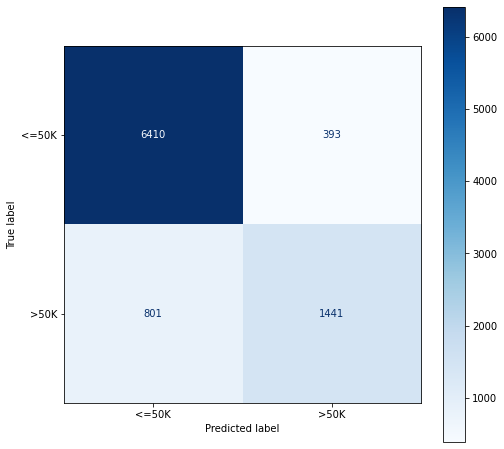

In [491]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgb_grid, X_test, y_test, values_format = "d", cmap=plt.cm.Blues, ax = ax)
plt.plot()

# Voting

In [312]:
def result_model(df,model, name):
    transformed_data = grouping_marital(df)
    y_hat, y_hat_proba = test_model(model,transformed_data,name)
    return y_hat, y_hat_proba, model

y_hat_xgb_imp, y_hat_xgb_imp, model_xgb_imp = result_model(df, XGBClassifier(model__booster='gbtree', model__eta = 0.16, model__eval_metric ='logloss',
                     model__max_depth = 7, model__reg_lambda = 10, model__scale_pos_weight = 1), "XGB_imp")


 XGB_imp cross validation accuarcy score: 0.8695        +/- 0.005 (std) 	 min: 0.8618,        max: 0.8764
[10:40:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { model__booster, model__eta, model__eval_metric, model__max_depth, model__reg_lambda, model__scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:40:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [313]:
estimators=[model_Rf, model_Lr, model_xgb_imp]

In [314]:
## !pip install mlxtend
from mlxtend.classifier import EnsembleVoteClassifier  #nie wymaga ponownego fitowania
import copy

In [347]:
voting_clf = EnsembleVoteClassifier(clfs=estimators, voting='soft', weights=[0.1, 0.1, 0.8], fit_base_estimators=False)

In [348]:
voting_model = get_pipeline(voting_clf)
voting_model.fit(X_train, y_train)
y_hat_v = voting_model.predict(X_test)
y_hat_prob_v = voting_model.predict_proba(X_test)[:, 1]

In [349]:
print(f"Bulit in:\n {classification_report(y_test, y_hat_v)}")
print(f"Roc_Auc_Score: {roc_auc_score(y_test, y_hat_prob_v)}\n")
print(f"Confusion matrix:\n {confusion_matrix(y_test, y_hat_v)}")

Bulit in:
               precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      6803
        >50K       0.78      0.64      0.70      2242

    accuracy                           0.87      9045
   macro avg       0.84      0.79      0.81      9045
weighted avg       0.86      0.87      0.86      9045

Roc_Auc_Score: 0.9256824172260678

Confusion matrix:
 [[6409  394]
 [ 811 1431]]


[]

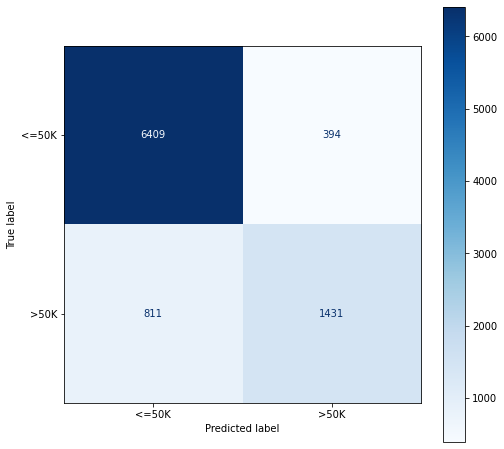

In [495]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(voting_model, X_test, y_test, values_format = "d", cmap=plt.cm.Blues, ax = ax)
plt.plot()

In [367]:
results = results_to_df("Voting", y_hat_v, y_hat_prob_v, y_test, results)

In [371]:
results

,model,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,LogisticRegression tuned,0.842676,0.835686,0.842676,0.836629,0.901309
1,LogisticRegression base,0.844002,0.837064,0.844002,0.837847,0.901488
2,RandomForest tuned,0.857380,0.851629,0.857380,0.851231,0.915571
3,RandomForest base,0.842012,0.836475,0.842012,0.838126,0.890946
4,XGB tuned,0.867772,0.863103,0.867772,0.863106,0.925537
5,XGB base,0.866003,0.861250,0.866003,0.861541,0.926215
6,Dummy,0.752128,0.565697,0.752128,0.645725,0.500000
7,XGB tuned improved,0.867993,0.863338,0.867993,0.863308,0.925761
0,Voting,0.866777,0.862003,0.866777,0.861928,0.925682


In [374]:
results = results.set_index("model").reindex(['Dummy', 'LogisticRegression base', 'LogisticRegression tuned', 
                                    'RandomForest base', 'RandomForest tuned', 'XGB base', 'XGB tuned', 
                                    'XGB tuned improved', 'Voting']).reset_index()

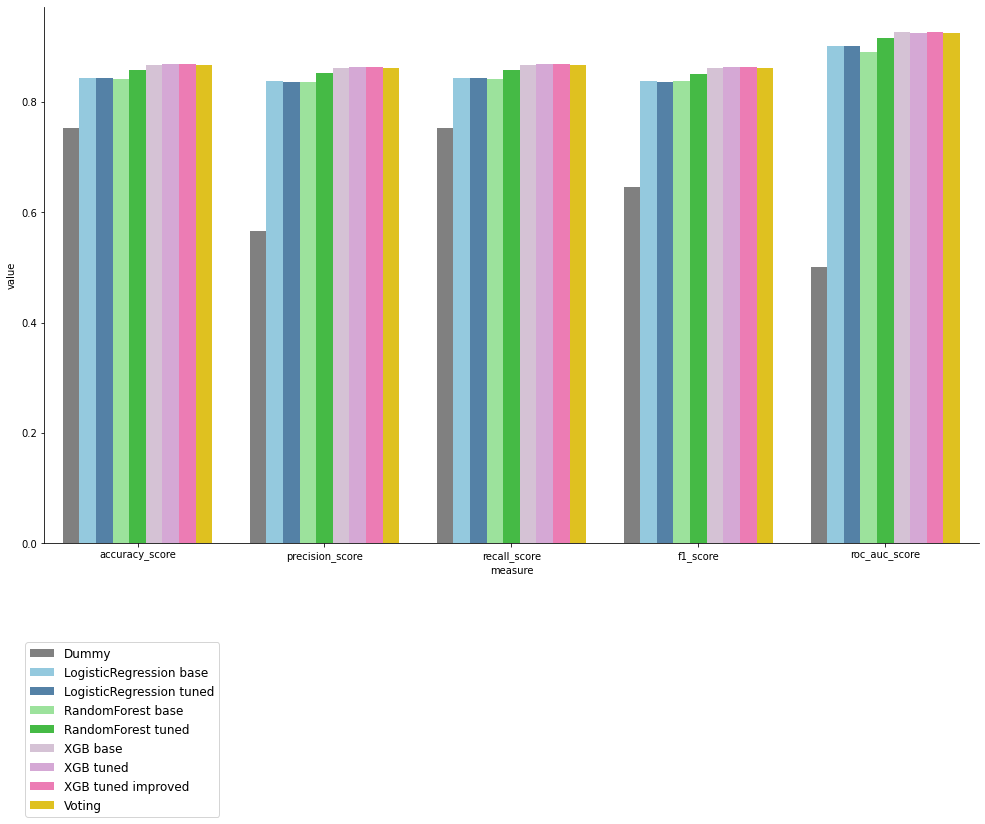

In [482]:
test_results_df = pd.melt(results, id_vars="model", var_name="measure", value_name="value")
g = sns.catplot(x='measure', y='value', hue='model', data=test_results_df, kind='bar', aspect=1.7, height = 8, 
            palette=sns.color_palette(['grey', 'skyblue', "steelblue", "lightgreen", "limegreen", 
                                       "thistle", "plum", "hotpink", "gold"]), legend_out = False)
g._legend.set_bbox_to_anchor((0.1, 0.1, 0.08, 0.2))
legend = plt.legend(loc=[-0.02, -0.51], fontsize='12')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

In [270]:
#df1 = df.copy()
#target_encoder = ce.TargetEncoder()
#target_encoder1 = ce.TargetEncoder()
#target_encoder2 = ce.TargetEncoder()
#target_encoder3 = ce.TargetEncoder()
#target_encoder4 = ce.TargetEncoder()
#target_encoder5 = ce.TargetEncoder()
#target_encoder6 = ce.TargetEncoder()
#target_encoder7 = ce.TargetEncoder()
#cat_features = ["workclass", "education", "marital_status",
#                    "occupation", "relationship", "race", 
#                    "sex", "native_country"]
#df1["income_level"] = df1.loc[:,"income_level"].map({'<=50K': 0, '>50K': 1})
#df1["workclass"] = target_encoder.fit_transform(df1["workclass"], df1["income_level"])
#df1["education"] = target_encoder1.fit_transform(df1["education"], df1["income_level"])
#df1["marital_status"] = target_encoder2.fit_transform(df1["marital_status"], df1["income_level"])
#df1["occupation"] = target_encoder3.fit_transform(df1["occupation"], df1["income_level"])
#df1["relationship"] = target_encoder4.fit_transform(df1["relationship"], df1["income_level"])
#df1["race"] = target_encoder5.fit_transform(df1["race"], df1["income_level"])
#df1["sex"] = target_encoder6.fit_transform(df1["sex"], df1["income_level"])
#df1["native_country"] = target_encoder7.fit_transform(df1["native_country"], df1["income_level"])
#X_c, y_c = pre_process(df1)

In [513]:
#pf = PolynomialFeatures(degree=1)
#X_features = pf.fit_transform(X_c)
#listFeat = pf.get_feature_names(X_c.columns)

In [514]:
#def feature_names(selector):
#    return np.array(pf.get_feature_names(X_c.columns))[selector.get_support()]

In [515]:
#def indexBest(k, bestFeat, listFeat):
#    chi2_selector = SelectKBest(chi2, k=k)
#    chi2_selector.fit_transform(X_features, y_c)
#    bestFeat = feature_names(chi2_selector)
#    indexs = []
#    for el in bestFeat:
#        idx = listFeat.index(el)
#        indexs.append(idx)
#    return indexs

In [516]:
#idx = indexBest(10, bestFeat, listFeat)

In [517]:
#X_c = pd.DataFrame(np.matrix(X_features)[:,idx])

In [518]:
#X_tr, X_te, y_tr, y_te = train_test_split(X_c, y_c,
#                        test_size = 0.2,
#                        random_state = 42,
#                        stratify= y_c)

In [538]:
#lr = LogisticRegression()
#lr.fit(X_tr, y_tr)
#y_hat = lr.predict(X_te)
#confusion_matrix(y_te, y_hat)


array([[6922,  509],
       [1023, 1315]])

In [539]:
#print(classification_report(y_te, y_hat))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7431
           1       0.72      0.56      0.63      2338

    accuracy                           0.84      9769
   macro avg       0.80      0.75      0.77      9769
weighted avg       0.84      0.84      0.84      9769

